# 데이터 전처리와 시각화 _ 20260209  

## **Mini Project : 영국시장의 중고자동차 가격 데이터 다루기**  

이전 학습에서 배웠던 Data transformation 기술을 활용하여 가이드에 따른 다양한 시도를 진행해 봅니다.    

-----

**[학습목표]**  
1. 데이터 결합, 그룹화를 통하여 요약된 정보를 나타낼 수 있는가?  
2. 데이터의 스케일을 변형하고, 각 스케일러의 특성을 이해하였는가?  
3. 원하는 만큼의 주성분을 추출하고, 기존 데이터에 대한 설명력을 제시할 수 있는가?   
  
**[프로젝트 수행 방법]**  
- 주 데이터 이름 : cars.csv    
- 보조 데이터 이름 : brand.csv  
  이번 프로젝트에서는 "중고차 가격 예측 모델"을 가정하여 데이터를 준비해 볼 수 있고, "중고차 특성에 따른 클러스터링"을 가정하여 데이터를 준비해 볼 수도 있습니다.     

**[프로젝트 수행 내역]**  
**Step 1.** 필수  
1. car.csv와 brand.csv의 데이터 합치기     
2. 카테고리형 변수를 숫자 형태로 변환하기 : Engine, Emission Class 변수 주목!!  
3. 결측치 처리하기 : Service history 변수의 결측치는 'Unknown'으로 채우고 결측치 변수가 일정 개수 이상 포함된 데이터는 제거합니다.  
4. Scaler 활용    
5. 기존 데이터의 정보 70% 이상을 가지는 수준에서 최소한의 주성분 추출(PCA)  

**Step 2.** 추가  
1. 국가별 총 브랜드 개수 확인  
2. 변수간 상관관계 확인   
 
**[평가기준]**
1. 데이터 결합 및 그룹화 기법을 활용하여 요약 정보를 정확하게 나타내었는가?  
2. 스케일링을 효과적으로 사용하고, 각 스케일러 특성에 대하여 이해하였는가?  
3. 원하는 주성분 분석에 필요한 데이터 추출이 가능하며, 추출 후에는 해당 데이터에 대해 해석 가능한가?  

---
## **📌 기초 데이터 확인**  


In [8368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
# plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [8369]:
car_df = pd.read_csv('cars.csv')
brand_df = pd.read_csv('brand.csv')

### **주 데이터 cars.csv 정보 확인**  

- shape : 3687 row x 13 columns 구성    
- dtypes: float64(3), int64(3), object(7)   
  - object 형태의 columns 데이터 확인  
    1. tilte : 455개 세부항목 -> 제조사를 분리하여 별도의 columns 작성 가능 
    2. Fuel type : 6개 세부항목 ('Diesel', 'Petrol', 'Petrol Plug-in Hybrid', 'Petrol Hybrid', 'Electric', 'Diesel Hybrid')  
    3. Body type : 10개 세부항목 ('Hatchback', 'Coupe', 'Estate', 'Saloon', 'Convertible', 'MPV', 'SUV', 'Minibus', 'Combi Van', 'Pickup')  
    4. Engine : 34개 세부항목 및 결측치 nan(0.8L ~ 2.8L / 3.0 ~ 3.3L / 3.5L / 3.7L / 4.2L ~ 4.4L / 4.8L / 5.0 L / 5.5L / 6.3L / 결측치 nan)    
       -> 표시형식이 [숫자 + 'L'] 형태로 'L' 제거 후 수치형 변수로 변환 가능  
    5. Gearbox : 2개 세부항목 ('Manual', 'Automatic')    
    6. Emission Class (유럽 배출가스 기준) : 6개 세부항목 및 결측치 (Euro 1 ~ Euro 6, nan)   
       - 자동차 배기가스 배출을 줄이기 위해 유럽연합에서 시행하고 있는 규제 기준   
       - Euro 1은 1992년 시행한 최초의 유럽 배출가스 규제 기준    
       - 결측치 처리에 있어서,    
         - 1992년 이전 등록된 차량과 이후의 차량에 대하여 구분하여 확인 필요      
         - Fuel type별 규제 등급 확인 필요    
       -> 표시형식이 ['Euro' + 숫자] 형태로 'Euro' 제거 후 수치형 변수로 변환 가능  
    7. Service history : 1개(full)과 nan   
       => 프로젝트 수행 내역 중 결측치에 대하여 'Unknown'으로 변환 진행   
       => 변환 후 columns 을 구성하는 세부항목은 'Full'과 'Unknown' 2개로 구성    
- 결측치 개수 및 비율 확인    
  - 결측치 비율 3% 이하 항목 ('Engine', 'Doors', 'Seats', Emission Class') : 추가적인 데이터와 관계를 확인 후 결측치 처리방법 등 결정    
  - 결측치 비율 35% 초과 항목 ('Previous Owners', 'Service history') : 데이터 분석에 있어 중요한 항목인 지 추가적 확인 후 결측치 처리 방법 등 결정  
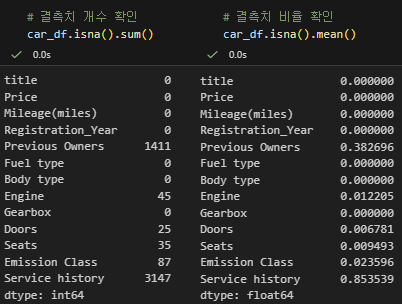

In [8370]:
# 주 데이터 형태 및 기초정보 확인
print(car_df.shape)
car_df.info()

(3687, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


In [8371]:
# data type object 확인 : 'title'
print('title항목 개수:', car_df['title'].nunique())
car_df['title'].unique()

title항목 개수: 455


array(['SKODA FABIA', 'VAUXHALL CORSA', 'HYUNDAI I30', 'MINI HATCH',
       'HYUNDAI COUPE', 'FORD FOCUS', 'VOLVO 740', 'PEUGEOT 207',
       'FORD FIESTA', 'VAUXHALL INSIGNIA', 'BMW 3 SERIES', 'CITROEN C1',
       'CITROEN C4', 'VAUXHALL ASTRA', 'FORD MONDEO',
       'MERCEDES-BENZ A180', 'PEUGEOT 407', 'FORD KA',
       'MERCEDES-BENZ A CLASS', 'MAZDA MAZDA2', 'SAAB 9-3',
       'VOLKSWAGEN POLO', 'BMW 1 SERIES', 'HONDA ACCORD',
       'VOLKSWAGEN BEETLE', 'MG MG6', 'FORD C-MAX', 'HONDA CIVIC',
       'TOYOTA AURIS', 'VOLVO S40', 'SEAT IBIZA', 'PEUGEOT 308',
       'VAUXHALL MERIVA', 'MERCEDES-BENZ B CLASS', 'MAZDA MAZDA3',
       'NISSAN 350 Z', 'ALFA ROMEO MITO', 'RENAULT FLUENCE',
       'VOLKSWAGEN PASSAT', 'KIA SPORTAGE', 'CITROEN XM',
       'VAUXHALL ANTARA', 'NISSAN NOTE', 'BMW 5 SERIES', 'HONDA CR-V',
       'PROTON SAVVY', 'NISSAN MICRA', 'FIAT PANDA', 'RENAULT MEGANE',
       'RENAULT CLIO', 'HYUNDAI I20', 'CITROEN C3', 'AUDI A6 SALOON',
       'TOYOTA YARIS', 'FIAT 500', 

In [8372]:
# data type object 확인 : 'Fuel type'
print('Fuel type 항목 개수:', car_df['Fuel type'].nunique())
car_df['Fuel type'].unique()

Fuel type 항목 개수: 6


array(['Diesel', 'Petrol', 'Petrol Plug-in Hybrid', 'Petrol Hybrid',
       'Electric', 'Diesel Hybrid'], dtype=object)

In [8373]:
# data type object 확인 : 'Body type'
print('Body type 항목 개수:', car_df['Body type'].nunique())
car_df['Body type'].unique()

Body type 항목 개수: 10


array(['Hatchback', 'Coupe', 'Estate', 'Saloon', 'Convertible', 'MPV',
       'SUV', 'Minibus', 'Combi Van', 'Pickup'], dtype=object)

In [8374]:
# data type object 확인 : 'Engine'
print('Engine 항목 개수:', car_df['Engine'].nunique())
car_df['Engine'].unique()

Engine 항목 개수: 34


array(['1.4L', '1.2L', '1.3L', '2.0L', '1.6L', '2.3L', '1.8L', '1.0L',
       '3.0L', '1.5L', '1.9L', '2.4L', '2.2L', '3.5L', '3.2L', '2.5L',
       '1.1L', '3.1L', '3.7L', '2.6L', '2.1L', '2.8L', '5.0L', '0.8L',
       '2.7L', '1.7L', '0.9L', '4.2L', nan, '4.4L', '4.3L', '3.3L',
       '5.5L', '4.8L', '6.3L'], dtype=object)

In [8375]:
# data type object 확인 : 'Gearbox'
print('Gearbox 항목 개수:', car_df['Gearbox'].nunique())
car_df['Gearbox'].unique()

Gearbox 항목 개수: 2


array(['Manual', 'Automatic'], dtype=object)

In [8376]:
# data type object 확인 : 'Emission Class' - 유럽 배출가스 기준
print('Emission Class 항목 개수:', car_df['Emission Class'].nunique())
car_df['Emission Class'].unique()

Emission Class 항목 개수: 6


array(['Euro 6', 'Euro 4', 'Euro 5', nan, 'Euro 3', 'Euro 2', 'Euro 1'],
      dtype=object)

In [8377]:
# data type object 확인 : 'Service history'
print('Service history 항목 개수:', car_df['Service history'].nunique())
car_df['Service history'].unique()

Service history 항목 개수: 1


array([nan, 'Full'], dtype=object)

In [8378]:
# 수치형 columns 자료 평균, 분산 및 분포 형태 확인
car_df.describe()

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats
count,3687.000000,3.687000e+03,3687.000000,2276.000000,3662.000000,3652.000000
mean,5787.301058,8.132854e+04,2011.846216,2.807557,4.321409,4.900329
std,4480.629885,3.941718e+04,5.082387,1.546028,0.986760,0.577046
min,400.000000,1.000000e+00,1953.000000,1.000000,2.000000,2.000000
25%,2490.000000,5.698400e+04,2008.000000,2.000000,3.000000,5.000000
50%,4000.000000,8.000000e+04,2012.000000,3.000000,5.000000,5.000000
75%,7995.000000,1.030000e+05,2015.500000,4.000000,5.000000,5.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000,5.000000,7.000000


In [8379]:
# 결측치 개수 확인
car_df.isna().sum()

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1411
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service history      3147
dtype: int64

In [8380]:
# 결측치 비율 확인
car_df.isna().mean()

title                0.000000
Price                0.000000
Mileage(miles)       0.000000
Registration_Year    0.000000
Previous Owners      0.382696
Fuel type            0.000000
Body type            0.000000
Engine               0.012205
Gearbox              0.000000
Doors                0.006781
Seats                0.009493
Emission Class       0.023596
Service history      0.853539
dtype: float64

In [8381]:
car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


### **보조 데이터 brand.csv 정보 확인**  

- shape : 48 row x 2 columns 구성    
- dtypes: object(2)   
  - object 형태의 columns 데이터 확인  
    1. tilte : 48개 세부항목 -> 주 데이터 car_df의 'title'항목에서 분리한 제조사 columns 과 맵핑되는지, 누락된 자료가 없는지 확인     
    2. country : 12개의 제조국 확인 ('Czech Republic', 'United Kingdom', 'South Korea', 'United States', 'Sweden', 'France', 'Germany', 'Japan', 'Spain', 'Italy', 'Malaysia', 'Romania')    
      **=> 제조사 title 항목을 기준으로 주 데이터와 보조 데이터의 병합 진행**  
- 결측치 유무 확인 : 없음   

In [8382]:
# 주 데이터 형태 및 기초정보 확인
print(brand_df.shape)
brand_df.info()

(48, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    48 non-null     object
 1   country  48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


In [8383]:
# data type object 확인 : 'title'
print('title항목 개수:', brand_df['title'].nunique())
brand_df['title'].unique()

title항목 개수: 48


array(['skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
       'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
       'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
       'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
       'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
       'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
       'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
       'lagonda', 'isuzu'], dtype=object)

In [8384]:
# data type object 확인 : 'country'
print('country항목 개수:', brand_df['country'].nunique())
brand_df['country'].unique()

country항목 개수: 12


array(['Czech Republic', 'United Kingdom', 'South Korea', 'United States',
       'Sweden', 'France', 'Germany', 'Japan', 'Spain', 'Italy',
       'Malaysia', 'Romania'], dtype=object)

In [8385]:
brand_df.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


---
## **Mission 1. 데이터 병합 : car.csv와 brand.csv의 데이터 합치기**

In [8386]:
car_df.head(10)

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN
5,HYUNDAI COUPE,800,124196,2007,3.0,Petrol,Coupe,2.0L,Manual,3.0,4.0,Euro 4,NaN
6,FORD FOCUS,798,140599,2008,NaN,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN
7,VAUXHALL CORSA,1995,90000,2009,NaN,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,NaN
8,VOLVO 740,750,225318,2025,NaN,Petrol,Estate,2.3L,Automatic,5.0,NaN,NaN,NaN
9,PEUGEOT 207,1299,87000,2008,5.0,Diesel,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN


In [8387]:
car_df.tail(10)

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
3677,ROVER 800,3975,34000,1995,NaN,Petrol,Saloon,2.7L,Automatic,4.0,NaN,NaN,NaN
3678,JEEP CHEROKEE,2750,100000,2004,3.0,Petrol,SUV,3.7L,Automatic,5.0,5.0,Euro 3,NaN
3679,HONDA PRELUDE,2475,156097,1998,2.0,Petrol,Coupe,2.2L,Automatic,2.0,4.0,Euro 2,Full
3680,CITROEN C3,1795,85962,2009,NaN,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 4,NaN
3681,NISSAN QASHQAI,1695,104000,2009,3.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN
3682,RENAULT MEGANE,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN
3683,AUDI A4,6990,119000,2012,NaN,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN
3684,BMW 3 SERIES,3995,139000,2013,NaN,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN
3685,HONDA ACCORD,1390,179190,2007,NaN,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full
3686,VAUXHALL CORSA,2000,82160,2013,7.0,Petrol,Hatchback,1.2L,Manual,5.0,5.0,Euro 5,NaN


### **Mission 1-1. car_df ['title'] 제조사 + 모델명 분리**

In [8388]:
# car_df 데이터 중 'title' columns 분리 : 제조사 / 모델명
# brand_df['title'].unique() 와 일치 : 48개 리스트 확인

brands = [
    'skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
    'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
    'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
    'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
    'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
    'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
    'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
    'lagonda', 'isuzu'
]

In [8389]:
def split_brand_model(title, brand_list):
    for brand in brand_list:
        if title.startswith(brand):
            model = title.replace(brand,'').strip()
            return brand, model
    # 찾지 못한 경우,
    parts = title.split(' ',1)
    return parts[0], parts[1] if len(parts) > 1 else None

car_df[['brand', 'model']] = car_df['title'].apply(
    lambda x: pd.Series(split_brand_model(x, brands))
)

In [8390]:
car_df

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,FABIA
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,CORSA
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,I30
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,HATCH
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,CORSA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,RENAULT MEGANE,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN,RENAULT,MEGANE
3683,AUDI A4,6990,119000,2012,NaN,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN,AUDI,A4
3684,BMW 3 SERIES,3995,139000,2013,NaN,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN,BMW,3 SERIES
3685,HONDA ACCORD,1390,179190,2007,NaN,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full,HONDA,ACCORD


In [8391]:
print('차량 제조사:',car_df['brand'].nunique())
car_df['brand'].unique()

차량 제조사: 48


array(['SKODA', 'VAUXHALL', 'HYUNDAI', 'MINI', 'FORD', 'VOLVO', 'PEUGEOT',
       'BMW', 'CITROEN', 'MERCEDES-BENZ', 'MAZDA', 'SAAB', 'VOLKSWAGEN',
       'HONDA', 'MG', 'TOYOTA', 'SEAT', 'NISSAN', 'ALFA', 'RENAULT',
       'KIA', 'PROTON', 'FIAT', 'AUDI', 'MITSUBISHI', 'LEXUS', 'LAND',
       'CHEVROLET', 'SUZUKI', 'DACIA', 'DAIHATSU', 'JEEP', 'JAGUAR',
       'CHRYSLER', 'ROVER', 'DS', 'DAEWOO', 'DODGE', 'PORSCHE', 'SUBARU',
       'INFINITI', 'ABARTH', 'SMART', 'MARCOS', 'MASERATI', 'SSANGYONG',
       'LAGONDA', 'ISUZU'], dtype=object)

In [8392]:
brand_df['title'].unique()

array(['skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
       'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
       'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
       'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
       'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
       'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
       'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
       'lagonda', 'isuzu'], dtype=object)

### **Mission 1-2. 병합 전 공통 columns 확인**

In [8393]:
# 병합 전 체크사항 : 
# 1. 병합 기준 칼럼명 통일 (*brand_df의 'title' 컬럼명을 'brand'로 변경)
brand_df.rename(columns={'title':'brand'},inplace=True)

In [8394]:
brand_df['brand'].unique()

array(['skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
       'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
       'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
       'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
       'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
       'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
       'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
       'lagonda', 'isuzu'], dtype=object)

In [8395]:
# 2. 각 데이터별 제조사명(brand) 일치 (*소문자 => 대문자) 

brand_df['brand'] = brand_df['brand'].str.upper()

In [8396]:
brand_df['brand'].unique()

array(['SKODA', 'VAUXHALL', 'HYUNDAI', 'MINI', 'FORD', 'VOLVO', 'PEUGEOT',
       'BMW', 'CITROEN', 'MERCEDES-BENZ', 'MAZDA', 'SAAB', 'VOLKSWAGEN',
       'HONDA', 'MG', 'TOYOTA', 'SEAT', 'NISSAN', 'ALFA', 'RENAULT',
       'KIA', 'PROTON', 'FIAT', 'AUDI', 'MITSUBISHI', 'LEXUS', 'LAND',
       'CHEVROLET', 'SUZUKI', 'DACIA', 'DAIHATSU', 'JEEP', 'JAGUAR',
       'CHRYSLER', 'ROVER', 'DS', 'DAEWOO', 'DODGE', 'PORSCHE', 'SUBARU',
       'INFINITI', 'ABARTH', 'SMART', 'MARCOS', 'MASERATI', 'SSANGYONG',
       'LAGONDA', 'ISUZU'], dtype=object)

In [8397]:
car_df['brand'].unique()

array(['SKODA', 'VAUXHALL', 'HYUNDAI', 'MINI', 'FORD', 'VOLVO', 'PEUGEOT',
       'BMW', 'CITROEN', 'MERCEDES-BENZ', 'MAZDA', 'SAAB', 'VOLKSWAGEN',
       'HONDA', 'MG', 'TOYOTA', 'SEAT', 'NISSAN', 'ALFA', 'RENAULT',
       'KIA', 'PROTON', 'FIAT', 'AUDI', 'MITSUBISHI', 'LEXUS', 'LAND',
       'CHEVROLET', 'SUZUKI', 'DACIA', 'DAIHATSU', 'JEEP', 'JAGUAR',
       'CHRYSLER', 'ROVER', 'DS', 'DAEWOO', 'DODGE', 'PORSCHE', 'SUBARU',
       'INFINITI', 'ABARTH', 'SMART', 'MARCOS', 'MASERATI', 'SSANGYONG',
       'LAGONDA', 'ISUZU'], dtype=object)

### **Mission 1-3. car_df와 brand_df 병합**

In [8398]:
# 데이터 병합 후 새로운 'usedcar_df' 이름으로 저장
usedcar_df = car_df.merge(brand_df, on='brand', how='left')

In [8399]:
usedcar_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,FABIA,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,CORSA,United Kingdom
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,I30,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,HATCH,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,CORSA,United Kingdom


---
## **Mission 2. 카테고리형 변수를 숫자형태로 변환**   
  
앞선 주 데이터 car_df 확인에서 카테고리형 변수 7개의 항목에 대하여 세부적으로 확인해 보았다. 이중 'Engine'과 'Emission' 컬럼의 경우, 숫자와 공통 문자('L' 또는 'Euro')로 결합된 형태임을 확인하였다.    

- Engine : 34개 세부항목 및 결측치 nan(0.8L ~ 2.8L / 3.0 ~ 3.3L / 3.5L / 3.7L / 4.2L ~ 4.4L / 4.8L / 5.0 L / 5.5L / 6.3L / 결측치 nan)    
       -> 표시형식이 [숫자 + 'L'] 형태로 **'L' 제거** 후 수치형 변수로 변환 가능   
- Emission Class (유럽 배출가스 기준) : 6개 세부항목 및 결측치 (Euro 1 ~ Euro 6, nan)   
  - 자동차 배기가스 배출을 줄이기 위해 유럽연합에서 시행하고 있는 규제 기준   
  - Euro 1은 1992년 시행한 최초의 유럽 배출가스 규제 기준    
  - 결측치 처리에 있어서,    
    - 1992년 이전 등록된 차량과 이후의 차량에 대하여 구분하여 확인 필요      
    - Fuel type별 규제 등급 확인 필요    
    -> 표시형식이 ['Euro' + 숫자] 형태로 **'Euro' 제거** 후 수치형 변수로 변환 가능  

In [8400]:
usedcar_df_raw = usedcar_df.copy()
usedcar_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
 13  brand              3687 non-null   object 
 14  model              3687 non-null   object 
 15  country            3687 non-null   object 
dtypes: float64(3), int64(3),

In [8401]:
# 'Engine' 컬럼의 데이터 변환
usedcar_df_raw['Engine'] =(
    usedcar_df_raw['Engine']
    .str.replace('L','',regex=False)  # 문자 'L'제거
    .astype(float)                     # 숫자형 변환
)   

In [8402]:
# 변환 내역 확인
usedcar_df_raw['Engine'].unique()

array([1.4, 1.2, 1.3, 2. , 1.6, 2.3, 1.8, 1. , 3. , 1.5, 1.9, 2.4, 2.2,
       3.5, 3.2, 2.5, 1.1, 3.1, 3.7, 2.6, 2.1, 2.8, 5. , 0.8, 2.7, 1.7,
       0.9, 4.2, nan, 4.4, 4.3, 3.3, 5.5, 4.8, 6.3])

In [8403]:
# 'Emission Class' 컬럼의 데이터 변환
usedcar_df_raw['Emission Class'] =(
    usedcar_df_raw['Emission Class']
    .str.replace('Euro ','',regex=False)  # 문자 'Euro'제거
    .astype(float)                     # 숫자형 변환
)   

In [8404]:
# 변환 내역 확인
usedcar_df_raw['Emission Class'].unique()

array([ 6.,  4.,  5., nan,  3.,  2.,  1.])

In [8405]:
# 카테고리형 -> 수치형 데이터 변환 확인
usedcar_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   float64
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   float64
 12  Service history    540 non-null    object 
 13  brand              3687 non-null   object 
 14  model              3687 non-null   object 
 15  country            3687 non-null   object 
dtypes: float64(5), int64(3),

---
## **Mission 3. 결측치 처리**   
 
- 결측치 비율 35% 초과 항목 :   
  - **'Service history'** : 서비스 점검 이력은 중고차 가격 결정에 영향을 미침   
                        점검 여부가 확인되지 않음 ('Unknown') 자체로 데이터 분석에 중요한 자료  
                        = > 결측치 fillna 함수를 이용하여 'Unknown' 반영   
  - **'Previous Owners'** : 데이터 분석에 있어 'Previous Owners' 실제 중고차 가격 형성에 크게 영향을 미치지 않는 요소이다. 중고차 가격은 실제 차량의 연식, 주행거리, 컨디션과 직접적인 연관을 가지므로, 해당 컬럼은 데이터 분석에 중요하지 않은 자료로서 삭제를 진행하도록 한다.     
- 결측치 비율 3% 이하 항목 ('Engine', 'Doors', 'Seats', Emission Class') : 상세내역 확인 후 결측치 처리방법 등 결정   

In [8406]:
usedcar_df_clean = usedcar_df_raw.copy()

In [8407]:
# 병합 데이터에서 결측치 확인하기
usedcar_df_clean.isna().sum()

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1411
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service history      3147
brand                   0
model                   0
country                 0
dtype: int64

In [8408]:
usedcar_df_clean.isna().mean()

title                0.000000
Price                0.000000
Mileage(miles)       0.000000
Registration_Year    0.000000
Previous Owners      0.382696
Fuel type            0.000000
Body type            0.000000
Engine               0.012205
Gearbox              0.000000
Doors                0.006781
Seats                0.009493
Emission Class       0.023596
Service history      0.853539
brand                0.000000
model                0.000000
country              0.000000
dtype: float64

### **Mission 3-1. 'Service history' 결측치 처리**  

: 해당 컬럼의 데이터는 'Full'과 결측치 nan으로 구성되어 있음을 확인하였다.    
  중고차 시장에서 'Service history'는 중고차 가격 형성에 영향을 미치는 하나의 요소로서 확인되지 않음('Unknown')도 중요한 정보로 작용할 수 있다.  
  이에 대하여 'Service history' 컬럼의 결측치 처리에 있어, 확인되지 않은 상태인 'Unknown'으로 표시하고 분석하는 데 반영하도록 한다.  

In [8409]:
# 결측치 'Unknown'으로 채우기
usedcar_df_clean['Service history'] = (
    usedcar_df_clean['Service history'].fillna('Unknown') 
)

In [8410]:
# 처리내역 확인
usedcar_df_clean['Service history'].unique()

array(['Unknown', 'Full'], dtype=object)

### **Mission 3-2. 'Previous Owners' 결측치 처리**  

: 데이터 분석에 있어 'Previous Owners' 실제 중고차 가격 형성에 크게 영향을 미치지 않는 요소이다. 중고차 가격은 실제 차량의 연식, 주행거리, 컨디션과 직접적인 연관을 가지므로, 해당 컬럼은 데이터 분석에 중요하지 않은 자료로서 **삭제**를 진행하도록 한다.    

In [8411]:
usedcar_df_clean.drop(['Previous Owners'],axis =1, inplace =True)

In [8412]:
# 'Previous Owners' 컬럼 삭제 내역 확인
usedcar_df_clean.head()

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
0,SKODA FABIA,6900,70189,2016,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,SKODA,FABIA,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,VAUXHALL,CORSA,United Kingdom
2,HYUNDAI I30,949,137000,2011,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,HYUNDAI,I30,South Korea
3,MINI HATCH,2395,96731,2010,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,MINI,HATCH,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,VAUXHALL,CORSA,United Kingdom


In [8413]:
usedcar_df_clean.describe()

,Price,Mileage(miles),Registration_Year,Engine,Doors,Seats,Emission Class
count,3687.000000,3.687000e+03,3687.000000,3642.000000,3662.000000,3652.000000,3600.000000
mean,5787.301058,8.132854e+04,2011.846216,1.606260,4.321409,4.900329,4.910000
std,4480.629885,3.941718e+04,5.082387,0.486584,0.986760,0.577046,0.910688
min,400.000000,1.000000e+00,1953.000000,0.800000,2.000000,2.000000,1.000000
25%,2490.000000,5.698400e+04,2008.000000,1.300000,3.000000,5.000000,4.000000
50%,4000.000000,8.000000e+04,2012.000000,1.600000,5.000000,5.000000,5.000000
75%,7995.000000,1.030000e+05,2015.500000,1.900000,5.000000,5.000000,6.000000
max,33900.000000,1.110100e+06,2025.000000,6.300000,5.000000,7.000000,6.000000


### **Mission 3-3. 수치형 데이터 ('Engine', 'Doors', 'Seats', 'Emission Class')의 결측치 처리**  

**[공통]** : 제조사(brand), 모델명 (model), 배기량(Engine), 제조년 (Registration_Year), 차종(Body type) 등을 조합하여 결측값 유추 가능  

**[수치형 결측치 상세내역 확인]**   
- **'Engine'** : 결측치 개수 : 45개 (비율 0.012205)   
                - 전기차(Fuel type = Electric)인 경우, 배기량 '0'으로 처리 (31건)    
- **'Doors'** : 결측치 개수 : 25개 (비율 0.006781)    
- **'Seats'** : 결측치 개수 : 34개 (비율 0.009493)    
- **'Emission Class'** : 결측치 개수 : 87개 (비율 0.023596)  

In [8414]:
for c in ['brand','model','Registration_Year','Body type','Engine','Emission Class']:
    print(c, usedcar_df_clean[c].apply(type).value_counts().head())


brand brand
<class 'str'>    3687
Name: count, dtype: int64
model model
<class 'str'>    3687
Name: count, dtype: int64
Registration_Year Registration_Year
<class 'int'>    3687
Name: count, dtype: int64
Body type Body type
<class 'str'>    3687
Name: count, dtype: int64
Engine Engine
<class 'float'>    3687
Name: count, dtype: int64
Emission Class Emission Class
<class 'float'>    3687
Name: count, dtype: int64


#### **Mission 3-3-1. 수치형 데이터 'Engine'의 결측치 처리**  

In [8415]:
# 'Engine' 컬럼 결측치와 관련하여 브랜드별 구분 : 제조사가 NISSAN인 차량에서 누락된 자료가 많음 
usedcar_df_clean[usedcar_df_clean['Engine'].isna()==True]['brand'].value_counts()

brand
NISSAN      30
VAUXHALL     3
TOYOTA       2
AUDI         2
MAZDA        2
FORD         2
BMW          1
CITROEN      1
FIAT         1
ISUZU        1
Name: count, dtype: int64

In [8416]:
# 'Engine' 컬럼 결측치와 관련하여 모델명 확인 및 모델별 결측치 개수 확인
usedcar_df_clean[usedcar_df_clean['Engine'].isna()==True]['model'].unique()

array(['3 SERIES', 'MARK X', 'CUBIC', 'A1', 'MAZDA6', 'FOCUS', 'C1', 'KA',
       'A3', 'PRIUS', 'MX-30', 'LEAF', '500L', 'ASTRA GTC', 'AMPERA',
       'TROOPER', 'CORSA'], dtype=object)

In [8417]:
usedcar_df[usedcar_df['Engine'].isna()==True]['model'].value_counts()

model
LEAF         29
3 SERIES      1
PRIUS         1
TROOPER       1
AMPERA        1
ASTRA GTC     1
500L          1
MX-30         1
A3            1
MARK X        1
KA            1
C1            1
FOCUS         1
MAZDA6        1
A1            1
CUBIC         1
CORSA         1
Name: count, dtype: int64

In [8418]:
# 결측치가 가장 많은 NISSAN LEAF 데이터 확인
# 2014년식 전기차량 (Fuel type = 'E;ectric') : 전기차량의 경우, 배기량 '0'
usedcar_df_clean[usedcar_df_clean['model']=='LEAF']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
2288,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2299,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2337,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2349,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2361,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2384,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2394,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2454,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2465,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan
2573,NISSAN LEAF,5390,60695,2014,Electric,Hatchback,NaN,Automatic,5.0,5.0,NaN,Unknown,NISSAN,LEAF,Japan


In [8419]:
# 'Engine' 결측치 처리 전략 
# 1. Fuel type == 'Electric' 인 경우(총 31건), '0' 
usedcar_df_clean.loc[
    (usedcar_df_clean['Fuel type'] == 'Electric') &
    (usedcar_df_clean['Engine'].isna()),
    'Engine'
] = 0

In [8420]:
usedcar_df_clean['Engine'].isna().sum()

np.int64(14)

In [8421]:
# '제조사 + 모델 + 차종 + 연료타입'으로 배기량 추정
engine_group_median = (
 usedcar_df_clean.groupby(['brand','model','Body type','Fuel type'])['Engine']
 .median())

In [8422]:
def fill_engine(row):
    if pd.isna(row['Engine']):
        return engine_group_median.get(
            (row['brand'], row['model'],row['Body type'],row['Fuel type']),
            np.nan
        )
    return row['Engine']

usedcar_df_clean['Engine'] = usedcar_df_clean.apply(fill_engine, axis=1)


In [8423]:
# 결측치 처리 후 미처리 내역 확인 : 최종 4개
usedcar_df_clean['Engine'].isna().sum()

np.int64(4)

In [8424]:
# 매칭 자료가 없는 데이터 모델명 확인
# 확인 결과, 4개의 항목은 비교 분석할 데이터가 존재하지 않고, 단독으로 존재  
# 해당 결측치를 삭제 처리
usedcar_df_clean[usedcar_df_clean['Engine'].isna()==True]['model'].unique()

array(['MARK X', 'CUBIC', 'AMPERA', 'TROOPER'], dtype=object)

In [8425]:
usedcar_df_clean[usedcar_df_clean['model']=='MARK X']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
835,TOYOTA MARK X,7500,77000,2021,Petrol,Saloon,NaN,Automatic,NaN,NaN,NaN,Unknown,TOYOTA,MARK X,Japan


In [8426]:
usedcar_df_clean[usedcar_df_clean['model']=='CUBIC']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
856,NISSAN CUBIC,4500,47000,2007,Petrol,Hatchback,NaN,Manual,NaN,NaN,NaN,Unknown,NISSAN,CUBIC,Japan


In [8427]:
usedcar_df_clean[usedcar_df_clean['model']=='AMPERA']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
3031,VAUXHALL AMPERA,9499,65767,2014,Petrol Plug-in Hybrid,Hatchback,NaN,Automatic,5.0,4.0,5.0,Unknown,VAUXHALL,AMPERA,United Kingdom


In [8428]:
usedcar_df_clean[usedcar_df_clean['model']=='TROOPER']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
3572,ISUZU TROOPER,2250,147700,2001,Diesel,SUV,NaN,Automatic,5.0,5.0,NaN,Unknown,ISUZU,TROOPER,Japan


In [8429]:
# 삭제 대상 모델 목록
remove_models = ['MARK X', 'CUBIC', 'AMPERA', 'TROOPER']

usedcar_df_clean = usedcar_df_clean[~usedcar_df_clean['model'].isin(remove_models)].copy()

In [8430]:
usedcar_df_clean['Engine'] = pd.to_numeric(usedcar_df_clean['Engine'], errors='coerce')

In [8431]:
# 최종 'Engine' 컬럼 미처리 결측치 개수 확인
usedcar_df_clean['Engine'].isna().sum()

np.int64(0)

In [8432]:
usedcar_df_clean['Engine'].unique()

array([1.4 , 1.2 , 1.3 , 2.  , 1.6 , 2.3 , 1.8 , 1.  , 3.  , 1.5 , 1.9 ,
       2.4 , 2.2 , 3.5 , 3.2 , 2.5 , 1.1 , 3.1 , 3.7 , 2.6 , 2.1 , 2.8 ,
       5.  , 0.8 , 2.7 , 1.7 , 0.9 , 4.2 , 4.4 , 4.3 , 3.3 , 1.65, 0.  ,
       5.5 , 4.8 , 6.3 ])

**※Mission 3-3-1. 수치형 데이터 'Engine'의 결측치 처리 정리**  

1. Fuel type이 'Electric'인 전기차의 경우, 엔진 배기량이 아닌 모터용량 개념으로 'Engine'을 0으로 처리하는 것이 합리적이다.    
2. 동일한 차량(brand, model, Body type, Fuel type 일치)일 경우, 차량의 배기량은 일치한다.    
3. 그럼에도 불구하고 비교 가능한 유사 차량 정보가 전혀 존재하지 않는 희귀 모델(MARK X, CUBIC, AMPERA, TROOPER)은 합리적인 근사치 산정이 불가능하여 분석 대상에서 제외하였다.    

#### **Mission 3-3-2. 수치형 데이터 'Doors'의 결측치 처리**  

In [8433]:
# 'Doors' 결측치 채우기 
# 동일한 제조사, 동일 모델, 제작년도, 차종이 일치하는 경우, Doors수가 일치할 것으로 추정 가능
doors_group_median = (
usedcar_df_clean.groupby(['brand','model','Body type'])['Doors']
.median())

In [8434]:
usedcar_df_clean['Doors'] = usedcar_df_clean.apply(
    lambda r: doors_group_median.get((r['brand'],r['model'],r['Body type']), r['Doors'])
    if pd.isna(r['Doors']) else r['Doors'],
    axis=1
)

In [8435]:
# # 결측치 처리 후 개수 확인
usedcar_df_clean['Doors'].isna().sum()

np.int64(6)

In [8436]:
# 결측치 확인 차량 모델명 확인
usedcar_df_clean[usedcar_df_clean['Doors'].isna()==True]['model'].unique()

array(['LAFESTA', 'FTO', 'ELGRAND', 'MARTINA', 'GTO', 'FIT'], dtype=object)

In [8437]:
# 결측치 확인 차량 모델명 확인
usedcar_df_clean[usedcar_df_clean['Doors'].isna()==True]['model'].value_counts()

model
LAFESTA    1
FTO        1
ELGRAND    1
MARTINA    1
GTO        1
FIT        1
Name: count, dtype: int64

In [8438]:
# 비교가능 유사 차량 정보 미존재 차량 : 삭제 진행 
# 삭제 대상 모델 목록
remove_models_doors = ['LAFESTA','FTO', 'ELGRAND', 'MARTINA', 'GTO','FIT']

usedcar_df_clean = usedcar_df_clean[~usedcar_df_clean['model'].isin(remove_models_doors)].copy()

In [8439]:
# # 결측치 처리 후 개수 확인
usedcar_df_clean['Doors'].isna().sum()

np.int64(0)

#### **Mission 3-3-3. 수치형 데이터 'Seats'의 결측치 처리**  

In [8440]:
# 'Seats' 결측치 채우기 
# 동일한 제조사, 동일 모델, 차종이 일치하는 경우, Seats수가 일치할 것으로 추정 가능
seats_group_median = (
usedcar_df_clean.groupby(['brand','model','Body type','Doors'])['Seats']
.median())

In [8441]:
usedcar_df_clean['Seats'] = usedcar_df_clean.apply(
    lambda r: seats_group_median.get((r['brand'],r['model'],r['Body type'], r['Doors']), r['Seats'])
    if pd.isna(r['Seats']) else r['Seats'],
    axis=1
)

In [8442]:
# 결측치 처리 후 개수 확인
usedcar_df_clean['Seats'].isna().sum()

np.int64(15)

In [8443]:
# 결측치 확인 차량 모델명 확인
usedcar_df_clean[usedcar_df_clean['Seats'].isna()==True]['model'].unique()

array(['740', 'XM', '260', 'MIDGET', 'MINI', 'CAMRY', '900', 'SUNNY',
       'BX', 'C1', 'PROTON', 'COMBO', 'LG6 ROADSTER', 'CARINA', '800'],
      dtype=object)

In [8444]:
usedcar_df_clean[usedcar_df_clean['Seats'].isna()==True]['model'].value_counts()

model
740             1
XM              1
260             1
MIDGET          1
MINI            1
CAMRY           1
900             1
SUNNY           1
BX              1
C1              1
PROTON          1
COMBO           1
LG6 ROADSTER    1
CARINA          1
800             1
Name: count, dtype: int64

In [8445]:
# 차량 CITROEN C1 (index 1533)과 동일 차량의 데이터를 비교
# 동일 조건의 다른 CITROEN C1 차량 데이터에서 Seats=4 가 일반적으로 나타남 
usedcar_df_clean[usedcar_df_clean['model']=='C1']

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
14,CITROEN C1,1100,164985,2008,Petrol,Hatchback,1.0,Manual,3.0,4.0,4.0,Unknown,CITROEN,C1,France
68,CITROEN C1,1490,65500,2008,Petrol,Hatchback,1.0,Manual,3.0,4.0,4.0,Unknown,CITROEN,C1,France
166,CITROEN C1,1390,97000,2011,Petrol,Hatchback,1.0,Manual,5.0,4.0,5.0,Unknown,CITROEN,C1,France
894,CITROEN C1,1750,95811,2011,Petrol,Hatchback,1.0,Manual,3.0,4.0,5.0,Unknown,CITROEN,C1,France
1514,CITROEN C1,2400,74000,2008,Petrol,Hatchback,1.0,Manual,3.0,4.0,4.0,Unknown,CITROEN,C1,France
1527,CITROEN C1,1795,91500,2006,Petrol,Hatchback,1.0,Manual,5.0,4.0,4.0,Unknown,CITROEN,C1,France
1533,CITROEN C1,3900,71000,2015,Petrol,Hatchback,1.0,Manual,4.0,NaN,NaN,Unknown,CITROEN,C1,France
2344,CITROEN C1,4800,63000,2011,Petrol,Hatchback,1.0,Automatic,5.0,4.0,5.0,Unknown,CITROEN,C1,France
2902,CITROEN C1,7295,31961,2018,Petrol,Hatchback,1.0,Manual,3.0,4.0,6.0,Unknown,CITROEN,C1,France
2969,CITROEN C1,4300,45000,2012,Petrol,Hatchback,1.0,Manual,5.0,4.0,5.0,Unknown,CITROEN,C1,France


In [8446]:
# 확인: 동일 브랜드+모델의 Seats 분포
usedcar_df_clean.loc[
    (usedcar_df_clean['brand'] == 'CITROEN') &
    (usedcar_df_clean['model'] == 'C1'),
    'Seats'
].value_counts()


Seats
4.0    14
Name: count, dtype: int64

In [8447]:
# 동일 브랜드 모델의 Seats 분포를 확인 후, 결측치에 해당 값 반영처리
usedcar_df_clean.loc[1533, 'Seats'] = 4

In [8448]:
# 비교가능 유사 차량 정보 미존재 차량 : 삭제 진행 
# 삭제 대상 모델 목록
remove_models_seats = ['740', 'XM', '260', 'MIDGET', 'MINI', 'CAMRY', '900',
       'SUNNY', 'BX', 'PROTON', 'COMBO', 'LG6 ROADSTER', 'CARINA',
       '800']

usedcar_df_clean = usedcar_df_clean[~usedcar_df_clean['model'].isin(remove_models_seats)].copy()

In [8449]:
# 결측치 처리 후 개수 확인
usedcar_df_clean['Seats'].isna().sum()

np.int64(0)

**※Mission 3-3-3. 수치형 데이터 'Seats'의 결측치 처리 정리**  

1. 동일한 차량(brand, model, Body type, Doors 일치)일 경우, 차량의 좌석수(Seats) 일치한다.    
2. 희귀 모델이 아닌 경우, 동일 브랜드 모델의 Seats 분포형태를 참고하여, 결측치에 반영한다. (CITROEN C1 (index 1533) 차량)   
3. 그럼에도 불구하고 비교 가능한 유사 차량 정보가 전혀 존재하지 않는 희귀 모델은 합리적인 근사치 산정이 불가능하여 분석 대상에서 제외하였다.    

#### **Mission 3-3-4. 수치형 데이터 'Emission Class'의 결측치 처리**  

In [8450]:
# 결측치 처리전 'Emission Class'결측치 개수 확인 : 
# 앞서 단일데이터로 비교 불가능한 데이터 삭제 반영 (당초 87개)
usedcar_df_clean['Emission Class'].isna().sum()

np.int64(68)

In [8451]:
# Emission Class 결측치 처리
# 1. 유럽배출가스 기준(Euro Emission) 제도 도입 : 1992년 
##   이전 제조 차량은 규제 대상에서 제외 
##   '1992년 이전 제조차량' : Emission Class = 0 (13개 데이터 반영)

usedcar_df_clean.loc[
    (usedcar_df_clean['Registration_Year'] < 1992) &
    (usedcar_df_clean['Emission Class'].isna()),
    'Emission Class'
] = 0


In [8452]:
# 2. 현재 유럽배출가스 기준에 있어, 전기차는 적용대상이 아님 
##   2026년 11월 신차부터 Euro 7이 시행될 예정
##   전기자동차와 수소자동차에 확대적용 예정
##   기존 전기자동차에는 소급 적용되지 않음
##   전기자동차(31건)에 대하여 Emission Class = -1 ('Not Applicable') 별도 구분 적용 필요

usedcar_df_clean.loc[
    (usedcar_df_clean['Fuel type'] == 'Electric') &
    (usedcar_df_clean['Emission Class'].isna()),
    'Emission Class'
] = -1

In [8453]:
# 결측치 처리 후 개수 확인
usedcar_df_clean['Emission Class'].isna().sum()

np.int64(33)

In [8454]:
# 동일한 제조사, 동일 모델, 연료타입, 배기량, 차종이 일치하는 경우, Emission Class가 일치할 것으로 추정 가능
emission_group_median = (
usedcar_df_clean.groupby(['brand','Registration_Year','Fuel type', 'Engine'])['Emission Class']
.median())

In [8455]:
def fill_emission(row):
    if pd.isna(row['Emission Class']) and row['Registration_Year'] >= 1992:
        return emission_group_median.get(
            (row['brand'],row['Registration_Year'], row['Fuel type'], row['Engine']),
            np.nan
        )
    return row['Emission Class']

usedcar_df_clean['Emission Class'] = usedcar_df_clean.apply(fill_emission, axis=1)


In [8456]:
# 'Engine' 컬럼 결측치와 관련하여 모델명 확인 및 모델별 결측치 개수 확인
usedcar_df_clean[usedcar_df_clean['Emission Class'].isna()==True]['model'].unique()

array(['ODYSSEY', 'CLK', 'POLO', 'FREED', 'YARIS', 'JAZZ', 'PRIUS',
       'MAZDA6', 'C1', 'LEON', 'PRIUS+', 'UP'], dtype=object)

In [8457]:
usedcar_df_clean[usedcar_df_clean['Emission Class'].isna()==True]['model'].value_counts()

model
POLO       3
PRIUS      3
ODYSSEY    1
CLK        1
FREED      1
YARIS      1
JAZZ       1
MAZDA6     1
C1         1
LEON       1
PRIUS+     1
UP         1
Name: count, dtype: int64

In [8458]:
# 결측치 처리 후 개수 확인
usedcar_df_clean['Emission Class'].isna().sum()

np.int64(16)

In [8459]:
# 삭제 대상 모델 목록   
remove_models_emission = ['ODYSSEY','FREED','PRIUS+']

usedcar_df_clean = usedcar_df_clean[~usedcar_df_clean['model'].isin(remove_models_emission)].copy()

In [8460]:
usedcar_df_clean['Emission Class'].isna().sum()

np.int64(13)

In [8461]:
usedcar_df_clean[usedcar_df_clean['Emission Class'].isna()==True]['model'].value_counts()

model
POLO      3
PRIUS     3
CLK       1
YARIS     1
JAZZ      1
MAZDA6    1
C1        1
LEON      1
UP        1
Name: count, dtype: int64

In [8462]:
# 미처리 결측치 13건에 대하여 'EURO EMISSION' 적용시점 반영 결측치 처리
# 'EURO Emission Class별 적용 시작연도
# EURO 1 (1992년), EURO 2 (1996년), EURO 3 (2000년), EURO 4 (2005년), EURO 5 (2009년), EURO 6 (2014년), EURO 7 (2026년 11월 이후)
# 차량 연식을 기준으로 매핑

# 차량 연식과 Euro Class 매핑 함수 설정
def infer_euro_class(year):
    if year < 1992:
        return 0
    elif year < 1996:
        return 1
    elif year < 2000:
        return 2
    elif year < 2005:
        return 3
    elif year < 2009:
        return 4
    elif year < 2014:
        return 5
    else:
        return 6

missing_emission = (
    usedcar_df_clean['Emission Class'].isna() &
    (usedcar_df_clean['Fuel type'] != 'Electric')
)

usedcar_df_clean.loc[missing_emission, 'Emission Class'] = (
    usedcar_df_clean.loc[missing_emission, 'Registration_Year']
    .apply(infer_euro_class)
)


In [8463]:
usedcar_df_clean['Emission Class'].isna().sum()

np.int64(0)

**※Mission 3-3-4. 수치형 데이터 'Emission Class'의 결측치 처리 정리**  

1. Euro Emission 제도 도입인 1992년을 기준으로 이전 생산 차량에 대하여 분리 후, '0' 처리    
2. 전기자동차의 경우, 배기량이 없으므로 현재 시점 Euro Emission 적용 대상이 아님 : '-1' (Not Applicable) 구분   
3. 결측치와 유사한 차량 모델의 정보를 기준으로 결측치 1차 반영  
4. 유사한 데이터를 확보할 수 없는 단독 데이터의 경우, 삭제 처리  
5. 그 외의 배출가스등급(EURO Emission Class) 결측치 처리에 있어 해당 차량의 연식과 유럽 배출가스 규제 도입 시점을 근거로 보정 처리     
    => 전기차의 경우, 배출가스가 없으므로 해당 데이터를 별도로 분리처리   

In [8464]:
usedcar_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3660 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3660 non-null   object 
 1   Price              3660 non-null   int64  
 2   Mileage(miles)     3660 non-null   int64  
 3   Registration_Year  3660 non-null   int64  
 4   Fuel type          3660 non-null   object 
 5   Body type          3660 non-null   object 
 6   Engine             3660 non-null   float64
 7   Gearbox            3660 non-null   object 
 8   Doors              3660 non-null   float64
 9   Seats              3660 non-null   float64
 10  Emission Class     3660 non-null   float64
 11  Service history    3660 non-null   object 
 12  brand              3660 non-null   object 
 13  model              3660 non-null   object 
 14  country            3660 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 457.5+ KB


In [8465]:
# 전기차 데이터 분리 
# : 전기차는 내연기관 차량이 아님
# => 내연기관에 적용되는 'Emission Class'나 'Engine' 배기량 분석에 섞을 경우 분포 왜곡 발생
usedcar_df_ev = usedcar_df_clean[usedcar_df_clean['Fuel type'].str.lower() == 'electric']
print(usedcar_df_ev.shape)
usedcar_df_ev.info()

(31, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 2194 to 3623
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              31 non-null     object 
 1   Price              31 non-null     int64  
 2   Mileage(miles)     31 non-null     int64  
 3   Registration_Year  31 non-null     int64  
 4   Fuel type          31 non-null     object 
 5   Body type          31 non-null     object 
 6   Engine             31 non-null     float64
 7   Gearbox            31 non-null     object 
 8   Doors              31 non-null     float64
 9   Seats              31 non-null     float64
 10  Emission Class     31 non-null     float64
 11  Service history    31 non-null     object 
 12  brand              31 non-null     object 
 13  model              31 non-null     object 
 14  country            31 non-null     object 
dtypes: float64(4), int64(3), object(8)
memory usage: 3.9+ KB


In [8466]:
# 전기차 제외 데이터 usedcar_df_ice
# (ICE : Internal Combustion Engine /연료를 태워서 동력을 생성하는 차량으로 Petrol, Diesel, Hybrid)
usedcar_df_ice = usedcar_df_clean[usedcar_df_clean['Fuel type'].str.lower() != 'electric']
usedcar_df_ice


,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
0,SKODA FABIA,6900,70189,2016,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,SKODA,FABIA,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,VAUXHALL,CORSA,United Kingdom
2,HYUNDAI I30,949,137000,2011,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,HYUNDAI,I30,South Korea
3,MINI HATCH,2395,96731,2010,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,MINI,HATCH,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,VAUXHALL,CORSA,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,RENAULT MEGANE,1395,76202,2006,Petrol,Hatchback,1.6,Manual,5.0,5.0,4.0,Unknown,RENAULT,MEGANE,France
3683,AUDI A4,6990,119000,2012,Petrol,Saloon,2.0,Manual,4.0,5.0,5.0,Unknown,AUDI,A4,Germany
3684,BMW 3 SERIES,3995,139000,2013,Diesel,Saloon,2.0,Manual,4.0,5.0,5.0,Unknown,BMW,3 SERIES,Germany
3685,HONDA ACCORD,1390,179190,2007,Diesel,Estate,2.2,Manual,5.0,5.0,4.0,Full,HONDA,ACCORD,Japan


In [8467]:
print(usedcar_df_ice.shape)
usedcar_df_ice.info()

(3629, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 3629 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3629 non-null   object 
 1   Price              3629 non-null   int64  
 2   Mileage(miles)     3629 non-null   int64  
 3   Registration_Year  3629 non-null   int64  
 4   Fuel type          3629 non-null   object 
 5   Body type          3629 non-null   object 
 6   Engine             3629 non-null   float64
 7   Gearbox            3629 non-null   object 
 8   Doors              3629 non-null   float64
 9   Seats              3629 non-null   float64
 10  Emission Class     3629 non-null   float64
 11  Service history    3629 non-null   object 
 12  brand              3629 non-null   object 
 13  model              3629 non-null   object 
 14  country            3629 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 453.6+ KB


In [8468]:
usedcar_df_ice.describe()

,Price,Mileage(miles),Registration_Year,Engine,Doors,Seats,Emission Class
count,3629.000000,3.629000e+03,3629.000000,3629.000000,3629.000000,3629.000000,3629.000000
mean,5789.112979,8.153327e+04,2011.918710,1.604312,4.316892,4.897492,4.908515
std,4499.751570,3.946555e+04,4.811984,0.485392,0.987459,0.574127,0.917733
min,400.000000,1.000000e+00,1987.000000,0.800000,2.000000,2.000000,0.000000
25%,2490.000000,5.698400e+04,2008.000000,1.300000,3.000000,5.000000,4.000000
50%,4000.000000,8.000000e+04,2012.000000,1.600000,5.000000,5.000000,5.000000
75%,7999.000000,1.032000e+05,2016.000000,1.900000,5.000000,5.000000,6.000000
max,33900.000000,1.110100e+06,2023.000000,6.300000,5.000000,7.000000,6.000000


In [8469]:
# 국가별 총 브랜드 개수 확인
usedcar_df_ice.groupby('country')['brand'].nunique()

country
Czech Republic     1
France             4
Germany            6
Italy              4
Japan             10
Malaysia           1
Romania            1
South Korea        4
Spain              1
Sweden             2
United Kingdom     6
United States      5
Name: brand, dtype: int64

In [8470]:
# 라이브러리 불러오기
from scipy import stats
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score
)
from sklearn.inspection import permutation_importance, partial_dependence

---
### **🔍Deep EDA (심층 탐색적 데이터 분석)**

#### **[데이터 로드 및 변수 재정의}**

**분석 방법**:  
- 내연기관 기반 차량만 모아둔 데이터셋(usedcar_df_ice)을 로드하고, 각 변수의 분포 등을 확인하며 특징을 확인한다. 

**세부 내역**  
- 차량 배기량('Engine') : 35개의 세분화된 정보를 실무적으로 의미 있는 **6개 등급**(유럽 Segment 기준 반영 : A~F, J,M,S)으로 재분류   
- 차량연료 ('Fuel type') : 차량의 연비와 관련된 변수   

**분석 이유**:   
- 중고차 시장에서는 차량의 매매가 이루어 진다.  
- 차량 구매에 있어서 첫번째로 고려되는 점이 사용용도와 예산이다.  
  - 구매자의 사용 목적에 따라 차량의 크기, 연비 등이 고려가 되고, 차량 구매 예산 범위 내에서 고려가 이루어진다.   
- 차량 판매자의 입장에서 동일한 조건의 차량에 있어 더 높은 가격을 받길 원한다.   

=> **이러한 시장의 특성을 파악하고, 현재 중고차 시장에서 가격을 결정하는 가장 중요한 요인이 어떤 것이 있는 지 확인하고자 한다.**  


In [8471]:
# usedcar_df_ice 내연기관 기반 차량 데이터 로드   

print(f"📊 Dataset Shape: {usedcar_df_ice.shape}")
print(f"\n📋 Columns ({len(usedcar_df_ice.columns)}개):")
print(usedcar_df_ice.columns.tolist())

# 결측치 확인
print(f"\n🔍 Missing Values:")
print(usedcar_df_ice.isnull().sum())

📊 Dataset Shape: (3629, 15)

📋 Columns (15개):
['title', 'Price', 'Mileage(miles)', 'Registration_Year', 'Fuel type', 'Body type', 'Engine', 'Gearbox', 'Doors', 'Seats', 'Emission Class', 'Service history', 'brand', 'model', 'country']

🔍 Missing Values:
title                0
Price                0
Mileage(miles)       0
Registration_Year    0
Fuel type            0
Body type            0
Engine               0
Gearbox              0
Doors                0
Seats                0
Emission Class       0
Service history      0
brand                0
model                0
country              0
dtype: int64


In [8472]:
usedcar_df_ice.head()

,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country
0,SKODA FABIA,6900,70189,2016,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,SKODA,FABIA,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,VAUXHALL,CORSA,United Kingdom
2,HYUNDAI I30,949,137000,2011,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,HYUNDAI,I30,South Korea
3,MINI HATCH,2395,96731,2010,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,MINI,HATCH,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,VAUXHALL,CORSA,United Kingdom


In [8473]:
# 'Engine (배기량)' 세부 내역 확인
print(usedcar_df_ice['Engine'].nunique(),'개')
sorted(usedcar_df_ice['Engine'].unique())

35 개


[np.float64(0.8),
 np.float64(0.9),
 np.float64(1.0),
 np.float64(1.1),
 np.float64(1.2),
 np.float64(1.3),
 np.float64(1.4),
 np.float64(1.5),
 np.float64(1.6),
 np.float64(1.65),
 np.float64(1.7),
 np.float64(1.8),
 np.float64(1.9),
 np.float64(2.0),
 np.float64(2.1),
 np.float64(2.2),
 np.float64(2.3),
 np.float64(2.4),
 np.float64(2.5),
 np.float64(2.6),
 np.float64(2.7),
 np.float64(2.8),
 np.float64(3.0),
 np.float64(3.1),
 np.float64(3.2),
 np.float64(3.3),
 np.float64(3.5),
 np.float64(3.7),
 np.float64(4.2),
 np.float64(4.3),
 np.float64(4.4),
 np.float64(4.8),
 np.float64(5.0),
 np.float64(5.5),
 np.float64(6.3)]

In [8474]:
usedcar_df_ice['Engine'].value_counts()

Engine
1.60    735
2.00    550
1.20    522
1.40    422
1.00    326
1.50    292
1.30    167
1.80    157
3.00     78
2.20     76
2.10     63
1.10     39
1.70     35
2.50     32
1.90     31
2.40     27
0.90     15
2.70     10
3.50     10
3.20      7
3.70      5
4.40      5
4.20      4
5.00      3
2.80      3
2.30      3
0.80      2
2.60      2
4.30      2
3.10      1
3.30      1
1.65      1
5.50      1
4.80      1
6.30      1
Name: count, dtype: int64

In [8475]:
# Engine 배기량에 따른 차종 구분 
# (유럽기준 세그먼트 Segment 분류 반영) : J 세그먼트의 경우, SUV 구분(같은 등급 내 경형, 소형, 중형, 대형 등 포함되어 이번 분석에서는 제외)

# A (경형): 1,000cc 미만/ 도시 주행에 최적화, 뛰어난 연비효율성
# B (소형): 1,000cc ~ 1,600cc 미만/도시 주행과 주차 편의성 중시, 안정적 주행 성능
# C (중형) : 1,600cc ~ 2,000cc 미만 / 도심주행과 고속도로 주행을 모두 고려
# D (준대형차) : 2,000cc ~ 2,500cc 미만 / 도심주행과 고속도로 주행을 모두 고려
# E,F (대형/일부SUV) : 2,500cc ~ 3,500cc
# M,S (다목적차량/스포츠카) : 3,500cc 초과

def engine_class(engine):
    if engine < 1.0:
        return '경차 : A'
    elif engine <= 1.6 :
        return '소형차 : B'
    elif engine <= 2.0 :
        return '중형차 : C'
    elif engine <= 2.5 :
        return '준대형차 : D'
    elif engine <= 3.5 :
        return '대형차 및 일부 SUV : E,F'   
    else:
        return '다목적차량, 스포츠카 : M,S'

usedcar_df_ice['segment'] = usedcar_df_ice['Engine'].apply(engine_class)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36988\1738799524.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usedcar_df_ice['segment'] = usedcar_df_ice['Engine'].apply(engine_class)


In [8476]:
# 클래스 분포
print(f"\n📈 Original Engine Distribution:")
print(usedcar_df_ice['Engine'].value_counts().sort_index())


📈 Original Engine Distribution:
Engine
0.80      2
0.90     15
1.00    326
1.10     39
1.20    522
1.30    167
1.40    422
1.50    292
1.60    735
1.65      1
1.70     35
1.80    157
1.90     31
2.00    550
2.10     63
2.20     76
2.30      3
2.40     27
2.50     32
2.60      2
2.70     10
2.80      3
3.00     78
3.10      1
3.20      7
3.30      1
3.50     10
3.70      5
4.20      4
4.30      2
4.40      5
4.80      1
5.00      3
5.50      1
6.30      1
Name: count, dtype: int64


In [8477]:
print(f"\n🎯 Recoded Class Distribution:")
class_dist = usedcar_df_ice['segment'].value_counts()
print(class_dist)
print(f"\nClass Ratio - A: {class_dist['경차 : A']/len(usedcar_df_ice)*100:.1f}%, B: {class_dist['소형차 : B']/len(usedcar_df_ice)*100:.1f}%, C: {class_dist['중형차 : C']/len(usedcar_df_ice)*100:.1f}%,D: {class_dist['준대형차 : D']/len(usedcar_df_ice)*100:.1f}%,E: {class_dist['대형차 및 일부 SUV : E,F']/len(usedcar_df_ice)*100:.1f}%,M: {class_dist['다목적차량, 스포츠카 : M,S']/len(usedcar_df_ice)*100:.1f}%")



🎯 Recoded Class Distribution:
segment
소형차 : B               2503
중형차 : C                774
준대형차 : D               201
대형차 및 일부 SUV : E,F     112
다목적차량, 스포츠카 : M,S       22
경차 : A                  17
Name: count, dtype: int64

Class Ratio - A: 0.5%, B: 69.0%, C: 21.3%,D: 5.5%,E: 3.1%,M: 0.6%


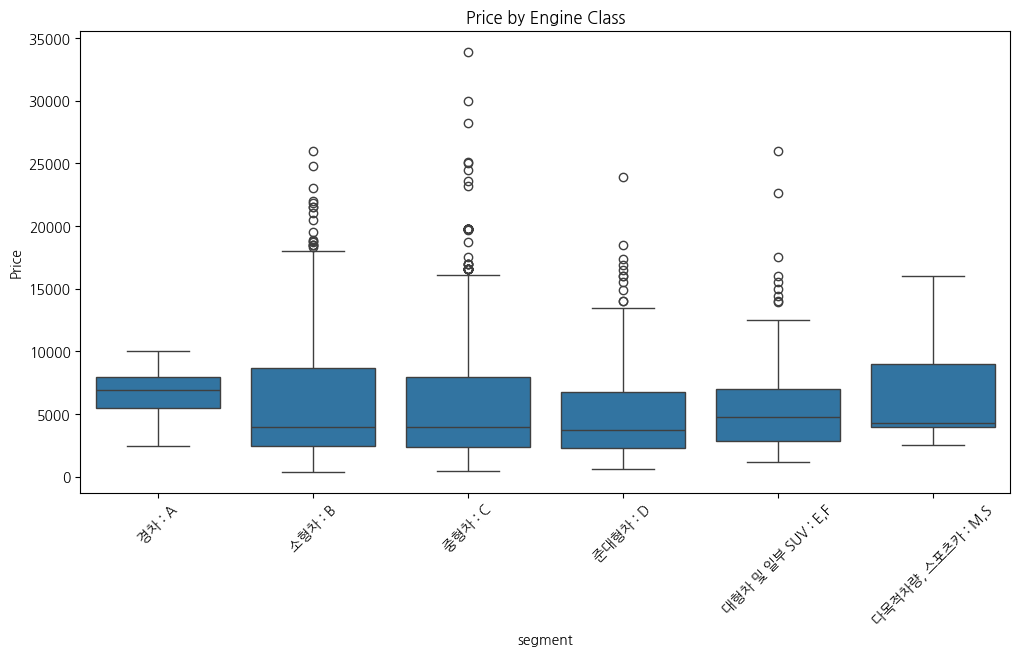

In [8478]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x='segment',
    y='Price',
    data=usedcar_df_ice,
    order=['경차 : A','소형차 : B','중형차 : C','준대형차 : D','대형차 및 일부 SUV : E,F','다목적차량, 스포츠카 : M,S']
)
plt.xticks(rotation=45)
plt.title('Price by Engine Class')
plt.show()

**그래프 분석**   
- 전체적으로 엔진 클래스(segment/배기량)가 커질 수록 '최소가격'과 '중앙값'이 전반적으로 상승한다.   
  (경차 A의 경우, 예외적인 형태를 나타낸다.)  
- 경차 A : 가격분포가 좁게 형성되어 있으며 이상치가 거의 확인되지 않음     
  => 안정적인 시장가격 형성   
  => 경차에 대한 가격 예측 정확도가 다른 등급에 비해 높음  
- 소형차 B 와 중형차 C : 가격분포가 가장 넓게 나타나는 구간임  
                        => 각 변수에 따라 가격차이가 큰 것 확인  

In [8479]:
pd.crosstab(
    usedcar_df_ice['segment'],
    usedcar_df_ice['Emission Class'],
    normalize='index'
)

Emission Class,0.0,1.0,2.0,3.0,4.0,5.0,6.0
segment,,,,,,,
경차 : A,0.000000,0.000000,0.000000,0.000000,0.058824,0.352941,0.588235
"다목적차량, 스포츠카 : M,S",0.000000,0.000000,0.000000,0.500000,0.363636,0.090909,0.045455
"대형차 및 일부 SUV : E,F",0.000000,0.000000,0.044643,0.098214,0.526786,0.267857,0.062500
소형차 : B,0.000000,0.000400,0.001199,0.021974,0.274870,0.337195,0.364363
준대형차 : D,0.004975,0.000000,0.014925,0.084577,0.383085,0.383085,0.129353
중형차 : C,0.003876,0.001292,0.016796,0.055556,0.311370,0.404393,0.206718


**crosstab 분포표 분석**    
- 경차 A : 중고차 시장에 나와있는 매물의 Emission Class는 Euro 5~6의 등급으로 최신 연식의 차량으로 추정할 수 있음    
- 소형차 B, 중형차 C : Euro 4~6의 등급에 고르게 분포    
                      앞선 데이터 분석에 있어 해당 등급의 데이터가 전체 중고차 데이터의 약 90% 차지    
                      => 중고차 시장의 '주력 라인업' 확인  

**[종합]**  
- 중고차 시장에서의 가격은 기본적으로 엔진 성능(배기량)이 결정한다고 추정할 수 있다.    
- 중고차 시장의 주된 매물은 소형차와 중형차이다. (가격 분포가 넓게 형성되어 있다.)   
  => 차량의 연식, Emission Class, 브랜드, 주행거리 등 다른 변수의 영향을 받는 것을 추가적으로 확인할 필요가 있다.  
- 배기량이 커질수록 Emission Class가 낮아질 가능성이 높다.  
  (고배기량 차량일 수록 친환경 규제가 적용되고, 가격에 영향을 미친다고 추정할 수 있다.)     

In [8480]:
# 샘플 확인
print(f"\n📄 Sample Data:")
display(usedcar_df_ice.head(10))


📄 Sample Data:


,title,Price,Mileage(miles),Registration_Year,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,brand,model,country,segment
0,SKODA FABIA,6900,70189,2016,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,SKODA,FABIA,Czech Republic,소형차 : B
1,VAUXHALL CORSA,1495,88585,2008,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,VAUXHALL,CORSA,United Kingdom,소형차 : B
2,HYUNDAI I30,949,137000,2011,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,HYUNDAI,I30,South Korea,소형차 : B
3,MINI HATCH,2395,96731,2010,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,MINI,HATCH,United Kingdom,소형차 : B
4,VAUXHALL CORSA,1000,85000,2013,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,VAUXHALL,CORSA,United Kingdom,소형차 : B
5,HYUNDAI COUPE,800,124196,2007,Petrol,Coupe,2.0,Manual,3.0,4.0,4.0,Unknown,HYUNDAI,COUPE,South Korea,중형차 : C
6,FORD FOCUS,798,140599,2008,Petrol,Hatchback,1.6,Manual,5.0,5.0,4.0,Unknown,FORD,FOCUS,United States,소형차 : B
7,VAUXHALL CORSA,1995,90000,2009,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Unknown,VAUXHALL,CORSA,United Kingdom,소형차 : B
9,PEUGEOT 207,1299,87000,2008,Diesel,Hatchback,1.6,Manual,5.0,5.0,4.0,Unknown,PEUGEOT,207,France,소형차 : B
10,FORD FIESTA,1495,181693,2009,Diesel,Hatchback,1.6,Manual,3.0,5.0,4.0,Full,FORD,FIESTA,United States,소형차 : B


---
#### **분포 분석 (Distribution Analysis)**

**분석 방법**:    
수치형 데이터 각각의 분포를 Histogram + KDE로 시각화하고, Skewness(왜도)와 Kurtosis(첨도)를 정량화한다.

**분석 이유**:
- **Skewness > 1 또는 < -1**: 분포가 심하게 치우쳐 있음 → 로그 변환 고려
- **극단적 Kurtosis**: 이상치가 많거나 분포가 뾰족함 → 아웃라이어 처리 필요
- 랜덤포레스트는 비선형 모델이라 정규성이 필수는 아니지만, 극단적 왜곡은 리프 노드의 평균값을 왜곡시킬 수 있습니다.

**결과 해석**:  
'Price', 'Mileage(miles)', 'Engine' 등이 강한 우측 왜곡(Positive Skew)을 보일 것으로 예상된다. 해당 변수에 있어 대부분 낮은 값을 가지지만, 일부 극단값이 존재함을 의미한다.


In [8481]:
usedcar_df_ice.columns.unique()

Index(['title', 'Price', 'Mileage(miles)', 'Registration_Year', 'Fuel type',
       'Body type', 'Engine', 'Gearbox', 'Doors', 'Seats', 'Emission Class',
       'Service history', 'brand', 'model', 'country', 'segment'],
      dtype='object')

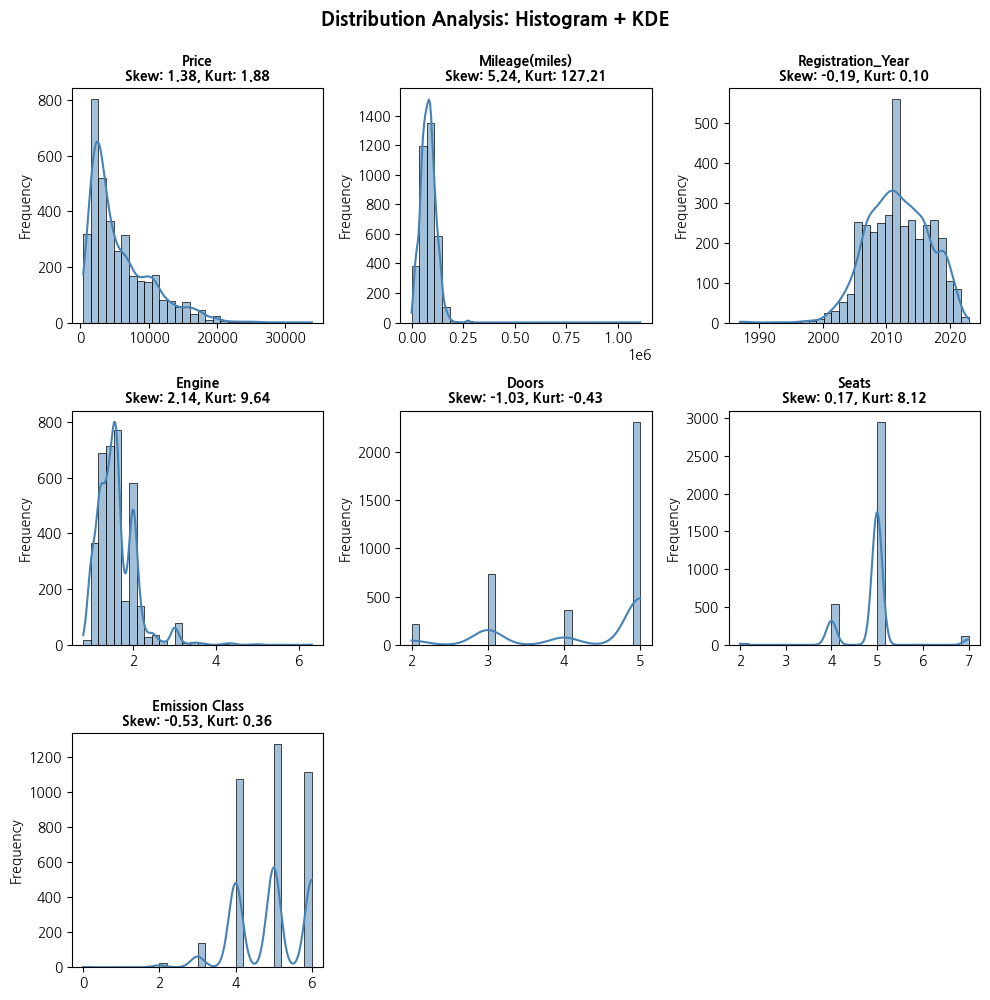


📊 Skewness & Kurtosis Summary (절댓값 큰 순서):


,Feature,Skewness,Kurtosis
1,Mileage(miles),5.240817,127.209712
3,Engine,2.135011,9.636470
0,Price,1.376213,1.881488
4,Doors,-1.033020,-0.429234
6,Emission Class,-0.531125,0.360130
2,Registration_Year,-0.187943,0.095116
5,Seats,0.174388,8.115462



💡 [Insight]
- Skewness > 1: 우측 꼬리가 긴 분포 (대부분 낮은 값, 일부 극단값)
- Skewness < -1: 좌측 꼬리가 긴 분포 (대부분 높은 값, 일부 낮은 값)
- 'Mileage'의 경우, 왜도와 첨도가 모두 높은 수치 확인 → 이상치 다수 존재, 'Price'는 로그 변환 고려할 수 있다.
- 정규분포를 가정할 수 없다.


In [8482]:
# 수치형 변수만 추출
numeric_cols = [
    'Price', 'Mileage(miles)', 'Registration_Year', 'Engine', 'Doors', 'Seats', 'Emission Class',
       ]

# 분포 시각화
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(usedcar_df_ice[col], kde=True, ax=ax, color='steelblue', bins=30)

    # Skewness 계산
    skew = usedcar_df_ice[col].skew()
    kurt = usedcar_df_ice[col].kurtosis()

    ax.set_title(f'{col}\nSkew: {skew:.2f}, Kurt: {kurt:.2f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# 빈 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution Analysis: Histogram + KDE', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Skewness 요약 테이블
skew_summary = pd.DataFrame({
    'Feature': numeric_cols,
    'Skewness': [usedcar_df_ice[col].skew() for col in numeric_cols],
    'Kurtosis': [usedcar_df_ice[col].kurtosis() for col in numeric_cols]
}).sort_values('Skewness', key=abs, ascending=False)

print("\n📊 Skewness & Kurtosis Summary (절댓값 큰 순서):")
display(skew_summary)

print("\n💡 [Insight]")
print("- Skewness > 1: 우측 꼬리가 긴 분포 (대부분 낮은 값, 일부 극단값)")
print("- Skewness < -1: 좌측 꼬리가 긴 분포 (대부분 높은 값, 일부 낮은 값)")
print("- 'Mileage'의 경우, 왜도와 첨도가 모두 높은 수치 확인 → 이상치 다수 존재, 'Price'는 로그 변환 고려할 수 있다.")
print("- 정규분포를 가정할 수 없다.")


---
#### **이상치 탐지 (Outlier Detection)**

**분석 방법**:    
앞선 데이터 분포에서 Skewness(왜도)와 Kurtosis(첨도) 결과를 통하여 각 변수의 이상치를 예상할 수 있었다. 이에 대하여 IQR을 기준으로 이상치 개수와 비율을 정량화하고, Box Plot으로 각 변수의 이상치를 시각화해본다.  

**IQR 기준**:
- Lower Bound = Q1 - 1.5 × IQR
- Upper Bound = Q3 + 1.5 × IQR
- 이 범위를 벗어난 값은 이상치로 간주

**결과 해석**:   
- 'Seats' 는 그래프를 통해 특정값 5에 집중적으로 몰려있는 것을 재확인하였다.

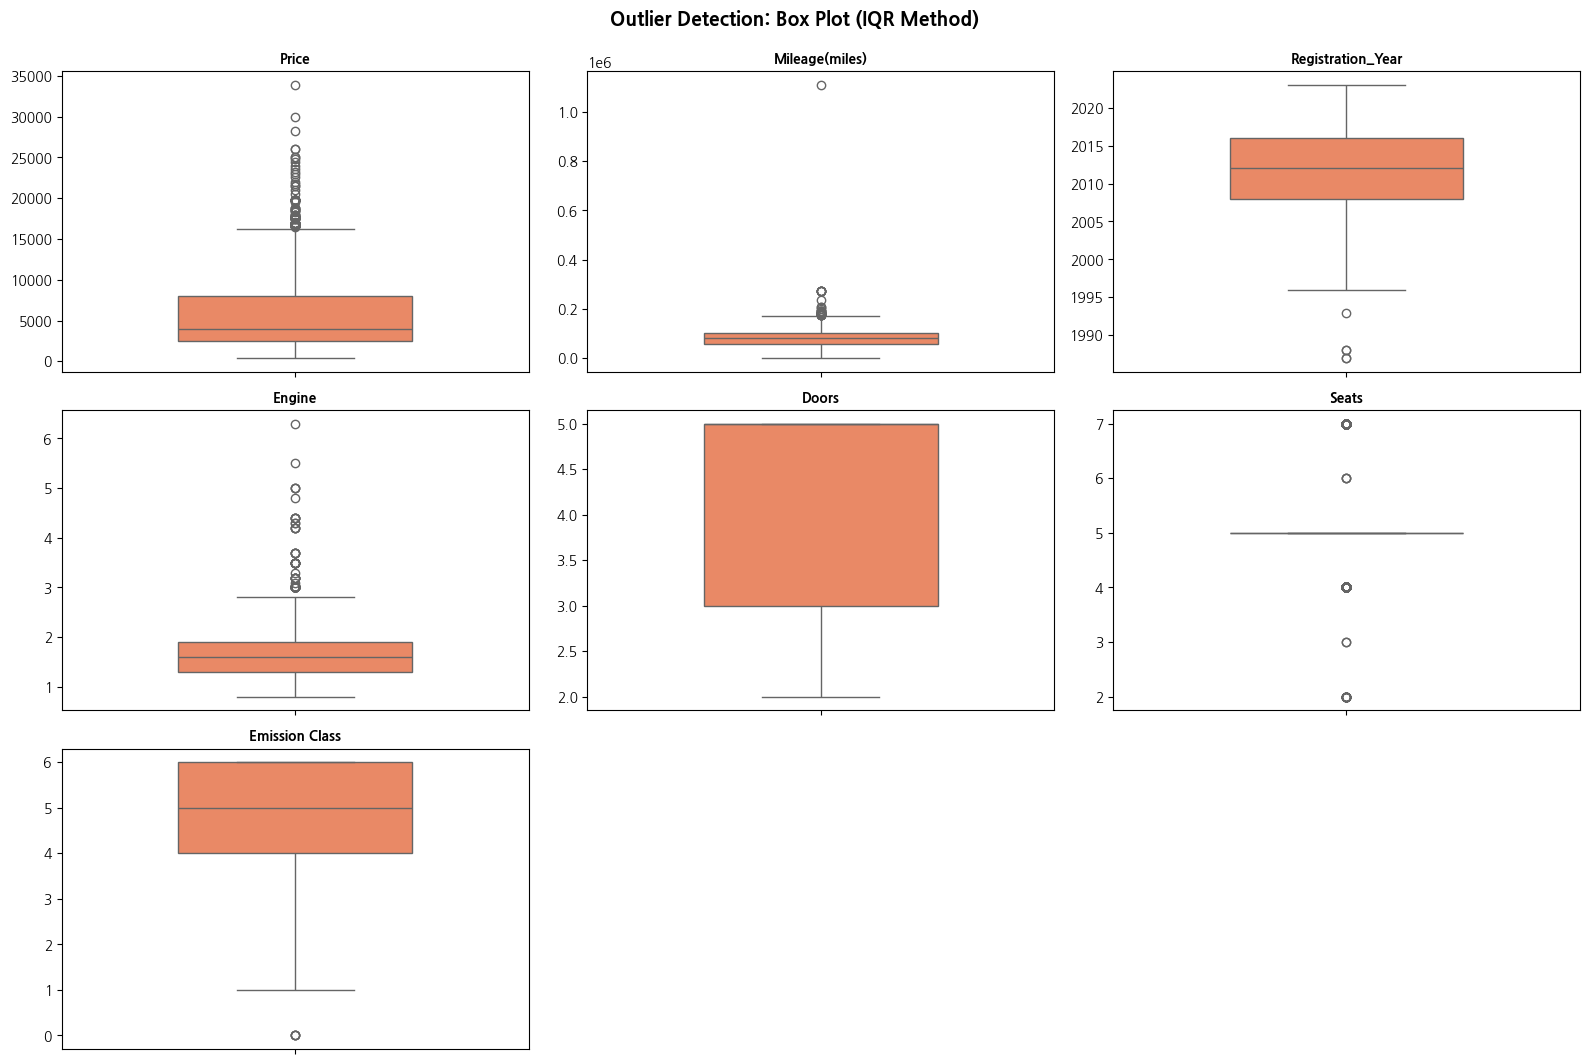


📊 Outlier Summary (IQR Method):


,Feature,Outlier_Count,Outlier_Ratio(%)
5,Seats,682,18.79
0,Price,124,3.42
3,Engine,119,3.28
1,Mileage(miles),33,0.91
2,Registration_Year,5,0.14
6,Emission Class,4,0.11
4,Doors,0,0.00



💡 [Decision]
- Seats의 경우, 이상치 비율이 모두 18.79% 로, 특정 값 5에 몰렸있음을 확인할 수 있다.


In [8483]:
# 이상치 탐지
fig, axes = plt.subplots(4, 3, figsize=(16, 14))
axes = axes.ravel()

outlier_summary = []

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(y=usedcar_df_ice[col], ax=ax, color='coral', width=0.5)
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_ylabel('')

    # IQR 기반 이상치 계산
    Q1 = usedcar_df_ice[col].quantile(0.25)
    Q3 = usedcar_df_ice[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = usedcar_df_ice[(usedcar_df_ice[col] < lower) | (usedcar_df_ice[col] > upper)]
    outlier_count = len(outliers)
    outlier_ratio = outlier_count / len(usedcar_df_ice) * 100

    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Outlier_Ratio(%)': round(outlier_ratio, 2)
    })

# 빈 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Outlier Detection: Box Plot (IQR Method)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 이상치 요약
outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Count', ascending=False)
print("\n📊 Outlier Summary (IQR Method):")
display(outlier_df)

print("\n💡 [Decision]")
print(f"- Seats의 경우, 이상치 비율이 모두 18.79% 로, 특정 값 5에 몰렸있음을 확인할 수 있다.")

---
## **Mission 4. Scaler**   

**분석방법**   
- 앞서 데이터의 분포와 이상치 확인 내역을 반영하여 스케일링을 진행한다.    
- 'Mileage(miles)'와 같은 극단적인 변수는 평균과 표준편차를 왜곡시키므로 모두 동일한 스케일링 방법을 적용해서는 안된다.   
- 왜도(Skewness)가 큰 변수('Mileage(miles)', 'Engine', 'Price')의 경우 로그로 변환하여 왜도 효과를 감소시킨다.   

**스케일링: Robust Scaling**    
- 중앙값 + IQR 사용   
- Standard Scaling과 비슷하나, 아웃라이어의 영향 없음 (극단값에 안정적)    
- 정규분포를 따르지 않는 데이터에 사용 적합

In [8484]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

df_pca = usedcar_df_ice.copy()

df_pca['Price_log'] = np.log1p(df_pca['Price'])
df_pca['Mileage_log'] = np.log1p(df_pca['Mileage(miles)'])
df_pca['Engine_log'] = np.log1p(df_pca['Engine'])

# 주성분 분석을 위한 변수 설정 
# : Doors, Seats와 같이 범주적 성격을 나타내는 데이터 제외
#  * Price의 경우, 해당 데이터 학습을 통하여 궁극적으로 예측하고자 하는 "중고차 가격(타깃)"에 해당
 
pca_features = [
    'Mileage_log',
    'Engine_log',
    'Registration_Year',
    'Emission Class'
]

In [8485]:
df_pca.columns

Index(['title', 'Price', 'Mileage(miles)', 'Registration_Year', 'Fuel type',
       'Body type', 'Engine', 'Gearbox', 'Doors', 'Seats', 'Emission Class',
       'Service history', 'brand', 'model', 'country', 'segment', 'Price_log',
       'Mileage_log', 'Engine_log'],
      dtype='object')

In [8486]:
# Robust Scaler : df_pca[pca_features] - df_pca[pca_features].min() / df_pca[pca_features].max() - df_pca[pca_features].min()
# 학습 및 연산

rs = RobustScaler()
X_scaled = rs.fit_transform(df_pca[pca_features])

In [8487]:
df_pca[pca_features].columns

Index(['Mileage_log', 'Engine_log', 'Registration_Year', 'Emission Class'], dtype='object')

In [8488]:
# 데이터프레임 형태로 전환 + columns 추가
rs_df = pd.DataFrame(rs.transform(df_pca[pca_features]),columns=df_pca[pca_features].columns )

In [8489]:
rs_df.head()

,Mileage_log,Engine_log,Registration_Year,Emission Class
0,-0.220299,-0.345307,0.500,0.5
1,0.171639,-0.720677,-0.500,-0.5
2,0.905805,-0.345307,-0.125,0.0
3,0.319765,-0.345307,-0.250,-0.5
4,0.102079,-0.528911,0.125,0.0


In [8490]:
rs_df.describe() # 평균과 표준편차가 0과 1이 아님 (정규분포가 아님)

,Mileage_log,Engine_log,Registration_Year,Emission Class
count,3629.000000,3629.000000,3629.000000,3629.000000
mean,-0.188926,-0.057083,-0.010161,-0.045743
std,1.049989,0.722367,0.601498,0.458867
min,-17.842764,-1.586377,-3.125000,-2.500000
25%,-0.571235,-0.528911,-0.500000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.428765,0.471089,0.500000,0.500000
max,4.428707,4.453648,1.375000,0.500000


---
## **Mission 5. PCA 분석 (70% 이상)**  
  
**개념**  
- **PCA(Principal Component Analysis)** : 차원 축소를 위한 기술. 데이터의 주요 특성을 유지하면서 차원을 줄여 계산 효율성을 높임   
  - PC1 : 데이터의 특성을 가장 잘 나타내는 주성분  
  - PC2 : PC1과 직교하는 주성분  
- explained_variance_ratio_ : 주성분 분석(PCA)와 같은 차원 축소 기법에서 사용되는 속성. 각 주성분이 원본 데이터의 분산(variance)을 얼마나 설명하는지에 대한 비율   
  
#### **주성분 분석(PCA)** 

In [8491]:
# 라이브러리 불러오기
from sklearn.decomposition import PCA

pca=PCA()

In [8492]:
# 학습
pca.fit(df_pca[pca_features])

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [8493]:
# 연산 및 데이터프레임 형태 변환
pd.DataFrame(pca.transform(df_pca[pca_features]))

,0,1,2,3
0,4.202954,0.291720,0.318704,-0.039708
1,-4.020776,-0.077305,-0.203075,-0.193268
2,-0.925336,0.623823,0.141599,-0.118768
3,-2.061027,0.070482,-0.582843,-0.100380
4,1.069550,0.208586,-0.137045,-0.114716
...,...,...,...,...
3624,-5.979435,-0.268657,0.184730,-0.028270
3625,0.063711,0.529156,-0.017835,0.120062
3626,1.037384,0.709134,-0.226827,0.115153
3627,-5.049747,0.611519,-0.149986,0.123918


In [8494]:
# 주성분 개수 1개
pca=PCA(1)

In [8495]:
pd.DataFrame(pca.fit_transform(df_pca[pca_features]), columns=['PC1'])

,PC1
0,4.202954
1,-4.020776
2,-0.925336
3,-2.061027
4,1.069550
...,...
3624,-5.979435
3625,0.063711
3626,1.037384
3627,-5.049747


In [8496]:
# 얼마만큼의 정보를 가지고 있는지 확인 : explained_variance_ratio_
# 결과 확인 : 0.9814 -> 1개의 주성분으로 거의 100%에 가까운 정보 반영
(pca.explained_variance_ratio_).sum()

np.float64(0.981425076041433)

In [8497]:
pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained_Variance': pca.explained_variance_ratio_
})

,PC,Explained_Variance
0,PC1,0.981425


In [8498]:
# 주성분 해석 
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_features,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
)
display(loadings)

print("\n💡 [Decision]")
print(f"- 위 데이터를 근거로, PC1은 '차량의 연식'을 표현하는 변수로 정의할 수 있다.")

,PC1
Mileage_log,-0.059764
Engine_log,-0.010437
Registration_Year,0.982957
Emission Class,0.173534



💡 [Decision]
- 위 데이터를 근거로, PC1은 '차량의 연식'을 표현하는 변수로 정의할 수 있다.


**결과 해석**  
- 위 자료 PC1은 4개의 변수를 하나의 축으로 압축한 '가중합'  
- PC1을 사실상 결정하는 변수는 'Registration_Year(0.983)'으로 거의 1에 해당  
  => PC1은 '차량의 연식'을 거의 그대로 표현하는 축을 나타냄  
  => 차량 연식과 중고차 가격은 매우 높은 상관관계를 확인할 수 있다.  
- (+) 부호 :  
  - Registration_Year : (↑) 최신 차량  
  - Emission Class : (↑) 최근 규제 -> 강화된 배출 규제  
- (-) 부호 :  
  - Mileage : (↑) 주행거리가 많다 -> 오래 되었거나 차량 성능 저하  
  
=> 첫 번째 주성분(PC1)은 차량 등록 연식과 배출가스 등급의 영향을 강하게 반영하며, 차량의 최신성과 환경 규제 수준을 나타내는 축으로 해석된다.   
※**주성분 해석**을 통해 얻을 결과로 PC1을 설명할 수 있는 이름 설정 가능  

In [8499]:
pca=PCA()
pd.DataFrame(pca.fit_transform(df_pca[pca_features]))
pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained_Variance': pca.explained_variance_ratio_
})

,PC,Explained_Variance
0,PC1,0.981425
1,PC2,0.012775
2,PC3,0.004817
3,PC4,0.000983


In [8500]:
# 주성분 해석 
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_features,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
)
display(loadings)

,PC1,PC2,PC3,PC4
Mileage_log,-0.059764,0.979938,-0.176186,-0.071469
Engine_log,-0.010437,0.069990,-0.011781,0.997424
Registration_Year,0.982957,0.027746,-0.181622,0.006194
Emission Class,0.173534,0.184534,0.967385,0.000293


**PC2 해석**  
- Mileage(주행거리) 비중이 지배적이며, Engine도 함께 작용  
- 주행거리가 많고, 상대적으로 엔진이 큰 차량  
  => 사용 강도 

**PC3 해석**  
- Emission Class 비중이 지배적  
- '환경규제'와 관련된 항목으로 PC3이 작을 수록 '친환경/최신 강화된 규제 적용' 차량

---
## **Mission 6. 각 변수간 상관관계 확인**    

**분석방법**  
- **Heatmap**: 변수 간 Pearson 상관계수를 색상으로 시각화 (상삼각 마스킹으로 깔끔하게)  
- **High Correlation Pairs**: |r| > 0.7인 변수 쌍을 자동 탐지  
- **Hierarchical Clustering**: 변수들을 유사도 기반으로 군집화하여 Dendrogram으로 시각화  
   
**분석 이유**:    
- **다중공선성(Multicollinearity)** 위험 탐지: 두 변수가 강하게 상관되어 있으면 하나는 제거 고려  
- 랜덤포레스트는 선형회귀와 달리 다중공선성에 덜 민감하지만, 해석 가능성(Interpretability)을 위해 확인 필요   
- Dendrogram은 "어떤 변수들이 비슷한 정보를 담고 있는가?"를 직관적으로 보여줍니다.   


In [8501]:
# Correlation Matrix
# 수치형 변수 대상 상관계수 확인
corr_matrix = df_pca[numeric_cols].corr()
corr_matrix

,Price,Mileage(miles),Registration_Year,Engine,Doors,Seats,Emission Class
Price,1.000000,-0.502219,0.772805,-0.025018,0.113188,-0.024566,0.690825
Mileage(miles),-0.502219,1.000000,-0.441586,0.334125,-0.035909,0.094059,-0.377696
Registration_Year,0.772805,-0.441586,1.000000,-0.296549,0.218835,0.031603,0.921190
Engine,-0.025018,0.334125,-0.296549,1.000000,-0.064356,0.071812,-0.263078
Doors,0.113188,-0.035909,0.218835,-0.064356,1.000000,0.499260,0.184382
Seats,-0.024566,0.094059,0.031603,0.071812,0.499260,1.000000,0.028755
Emission Class,0.690825,-0.377696,0.921190,-0.263078,0.184382,0.028755,1.000000


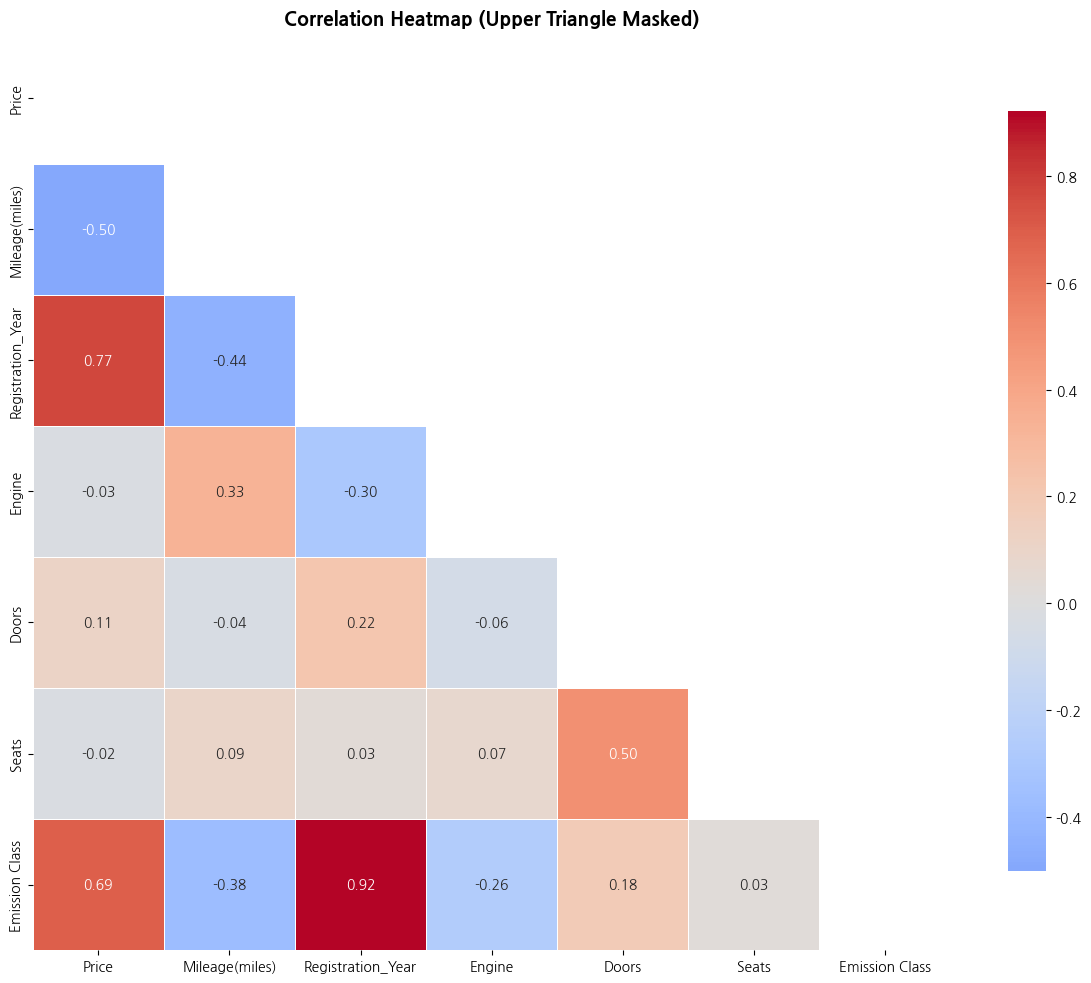


⚠️ High Correlation Pairs (|r| > 0.7):


,Var1,Var2,Correlation
0,Price,Registration_Year,0.773
1,Registration_Year,Emission Class,0.921


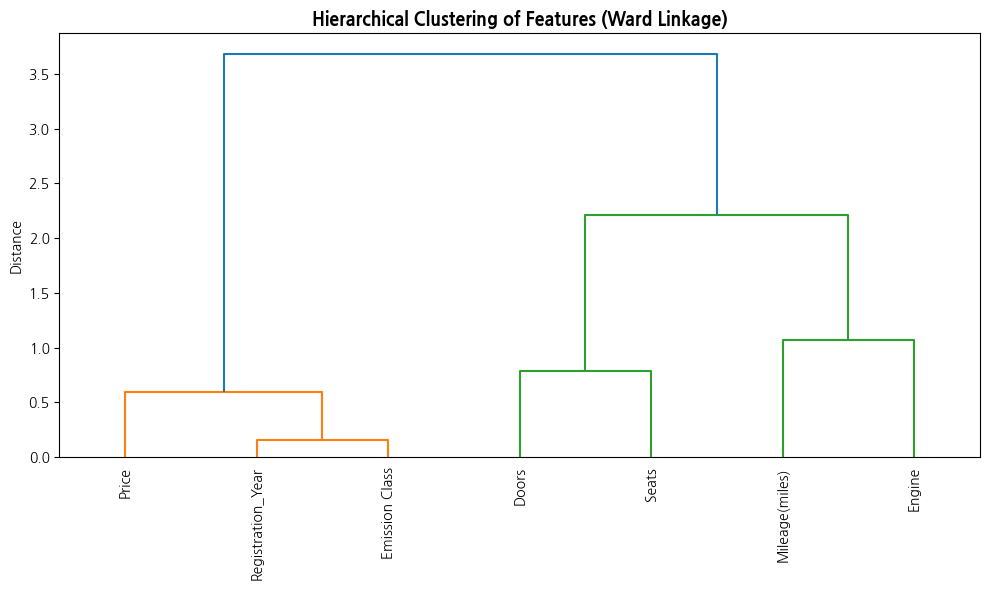


💡 [Insight]
- Dendrogram에서 가까이 붙은 변수들은 유사한 정보를 담고 있다.
- 예: 'Registration_Year'와 'Emission Class'는 한 클러스터로 묶일 가능성이 높다.


In [8502]:
# Heatmap with upper triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0, 
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title('Correlation Heatmap (Upper Triangle Masked)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# High correlation pairs (|r| > 0.7)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Var1': corr_matrix.columns[i],
                'Var2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

if high_corr:
    print("\n⚠️ High Correlation Pairs (|r| > 0.7):")
    display(pd.DataFrame(high_corr))
else:
    print("\n✅ 다중공선성 위험(|r| > 0.7)이 있는 변수 쌍 'Price'-'Registration_Year'(0.77), 'Registration_Year'-'Emission Class'(0.92)이 존재한다.")

# Hierarchical Clustering
linkage = hierarchy.ward(corr_matrix)
plt.figure(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    linkage, 
    labels=corr_matrix.columns, 
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering of Features (Ward Linkage)', fontsize=13, fontweight='bold')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

print("\n💡 [Insight]")
print("- Dendrogram에서 가까이 붙은 변수들은 유사한 정보를 담고 있다.")
print("- 예: 'Registration_Year'와 'Emission Class'는 한 클러스터로 묶일 가능성이 높다.")

---
## **Mission 7. PCA 기반 중고차 가격 회귀모델**     